# **Setup & Data Loading** 

In [55]:
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)

#### 1) Locate and load monthly CRMLS exports and adjust the folder

In [57]:
possible_dirs = ["./data", ".", "../data"]
csv_paths = []

for directory in possible_dirs:
    pattern = os.path.join(directory, "CRMLSSold*.csv")
    csv_paths.extend(glob(pattern))
    
# Sort and ensure we found files
csv_paths = sorted(set(csv_paths))
assert len(csv_paths) > 0, "No CRMLSSold*.csv files found --> check data path."

print(f"✅ Found {len(csv_paths)} monthly CRMLS files:")
for p in csv_paths:
    print("   •", os.path.basename(p))

✅ Found 7 monthly CRMLS files:
   • CRMLSSold202502.csv
   • CRMLSSold202503.csv
   • CRMLSSold202504.csv
   • CRMLSSold202505.csv
   • CRMLSSold202506.csv
   • CRMLSSold202507.csv
   • CRMLSSold202508.csv


#### 2) Read and merge all CSV files

In [58]:
dfs = []
for p in csv_paths:
    try:
        df_i = pd.read_csv(p, low_memory=False)
        df_i["__source_file"] = os.path.basename(p)
        dfs.append(df_i)
    except Exception as e:
        print(f"Skipping {p}: {e}")

# Concatenate all months
df_all_raw = pd.concat(dfs, ignore_index=True)
print(f"Loaded {len(df_all_raw):,} rows from {len(csv_paths)} files.")

Loaded 156,064 rows from 7 files.


# **STEP 1 --> DATA EXPLORATIONS**

#### 1.1 Parse Dates and Filter to Residential SFR

In [59]:
for col in ["CloseDate", "CloseDateTime", "COE", "COEDate", "CloseOfEscrowDate"]:
    if col in df_all_raw.columns:
        df_all_raw[col] = pd.to_datetime(df_all_raw[col], errors="coerce")

df_all = df_all_raw.copy()
df_all.head(5)

,BuyerAgentAOR,ListAgentAOR,Flooring,ViewYN,WaterfrontYN,BasementYN,PoolPrivateYN,OriginalListPrice,ListingKey,ListAgentEmail,CloseDate,ClosePrice,ListAgentFirstName,ListAgentLastName,Latitude,Longitude,UnparsedAddress,PropertyType,LivingArea,ListPrice,DaysOnMarket,ListOfficeName,BuyerOfficeName,CoListOfficeName,ListAgentFullName,CoListAgentFirstName,CoListAgentLastName,BuyerAgentMlsId,BuyerAgentFirstName,BuyerAgentLastName,FireplacesTotal,AssociationFeeFrequency,AboveGradeFinishedArea,ListingKeyNumeric,MLSAreaMajor,TaxAnnualAmount,CountyOrParish,MlsStatus,ElementarySchool,AttachedGarageYN,ParkingTotal,BuilderName,PropertySubType,LotSizeAcres,SubdivisionName,BuyerOfficeAOR,YearBuilt,StreetNumberNumeric,ListingId,BathroomsTotalInteger,City,TaxYear,BuildingAreaTotal,BedroomsTotal,ContractStatusChangeDate,ElementarySchoolDistrict,CoBuyerAgentFirstName,PurchaseContractDate,ListingContractDate,BelowGradeFinishedArea,BusinessType,StateOrProvince,CoveredSpaces,MiddleOrJuniorSchool,FireplaceYN,Stories,HighSchool,Levels,LotSizeDimensions,LotSizeArea,MainLevelBedrooms,NewConstructionYN,GarageSpaces,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet,MiddleOrJuniorSchoolDistrict,__source_file
0,RanchoSoutheast,RanchoSoutheast,NaN,True,NaN,NaN,NaN,60000.0,526199946,cmark1018@yahoo.com,2025-02-21,35000.0,Chris,Mark,34.536780,-117.273839,0 Quantico Road,Land,NaN,35000.0,196,Far West Realty,KW Vision,NaN,Chris Mark,NaN,NaN,TRSUDAJAM,James,Sudarsono,NaN,NaN,NaN,526199946,APPV - Apple Valley,NaN,San Bernardino,Closed,NaN,NaN,NaN,NaN,NaN,0.6428,NaN,TriCounties,NaN,0.0,RS21140713,NaN,Apple Valley,NaN,NaN,NaN,2025-02-21,NaN,NaN,2022-01-10,2021-06-28,NaN,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28000.0,NaN,False,NaN,NaN,92307,0.0,28000.0,NaN,CRMLSSold202502.csv
1,InlandValleys,InlandValleys,NaN,False,NaN,NaN,NaN,550000.0,525585060,mozcorona@aol.com,2025-02-14,625000.0,MANUEL,ZAMORANO,33.938547,-117.239639,24255 Sunnymead Boulevard,Land,NaN,550000.0,1232,"KAREN PIERCE, BROKER","KAREN PIERCE, BROKER",NaN,MANUEL ZAMORANO,NaN,NaN,ivzamoman,MANUEL,ZAMORANO,NaN,NaN,NaN,525585060,259 - Moreno Valley,NaN,Riverside,Closed,NaN,NaN,NaN,NaN,NaN,0.9100,NaN,InlandValleys,NaN,24255.0,IV21138689,NaN,Moreno Valley,NaN,NaN,NaN,2025-02-14,NaN,NaN,2024-11-08,2021-06-25,NaN,NaN,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39640.0,NaN,False,NaN,NaN,92553,0.0,39640.0,NaN,CRMLSSold202502.csv
2,SanDiego,SanDiego,NaN,False,NaN,NaN,False,880000.0,497696903,lenskab@gmail.com,2025-02-11,875000.0,Lenska,Bracknell,32.765380,-117.043486,4750 Dana Dr,Residential,2340.0,880000.0,20,LENSKA Realty,Coldwell Banker West,NaN,Lenska Bracknell,NaN,NaN,809976,Sheetal,Gandhi,NaN,NaN,NaN,497696903,91942 - La Mesa,NaN,San Diego,Closed,NaN,True,6.0,NaN,SingleFamilyResidence,NaN,La Mesa,PacificSouthwest,2021.0,4750.0,210000201,4.0,La Mesa,NaN,NaN,4.0,2025-02-11,NaN,NaN,2021-01-25,2021-01-05,NaN,NaN,CA,NaN,NaN,False,1.0,NaN,One,NaN,NaN,NaN,False,2.0,NaN,91942,NaN,NaN,NaN,CRMLSSold202502.csv
3,SanDiego,SanDiego,NaN,False,NaN,NaN,False,875000.0,497696407,lenskab@gmail.com,2025-02-14,875000.0,Lenska,Bracknell,32.765038,-117.043568,4740 Dana Dr,Residential,2165.0,875000.0,9,LENSKA Realty,LENSKA Realty,NaN,Lenska Bracknell,NaN,NaN,SAND-649841,Lenska,Bracknell,NaN,NaN,NaN,497696407,91942 - La Mesa,NaN,San Diego,Closed,NaN,True,4.0,NaN,SingleFamilyResidence,NaN,La Mesa,SanDiego,2021.0,4740.0,210000200,4.0,La Mesa,NaN,NaN,5.0,2025-02-14,NaN,NaN,2021-01-14,2021-01-05,NaN,NaN,CA,NaN,NaN,False,1.0,NaN,One,NaN,NaN,NaN,False,2.0,NaN,91942,NaN,NaN,NaN,CRMLSSold202502.csv
4,SanDiego,SanDiego,NaN,False,NaN,NaN,False,849000.0,486616176,lenskab@gmail.com,2025-02-18,849000.0,Lenska,Bracknell,32.765031,-117.043252,4730 Dana Dr,Residential,2158.0,849000.0,91,LENSKA Realty,Heritage Homes San Diego,NaN,Lenska Bracknell,NaN,NaN,SAND-693007,Jason,Piske,NaN,NaN,NaN,486616176,91942 - La Mesa,NaN,San Diego,Closed,NaN,True,4.0,NaN,SingleFamilyResidence,NaN,La Mesa,SanDiego,2021.0,4730.0,200049530,3.0,La Mesa,NaN,NaN,4.0,2025-02-18,

#### 1.2 Filter to Residential Single Family Residence

In [60]:
if "PropertyType" in df_all.columns:
    df_all = df_all[df_all["PropertyType"].astype(str).str.strip().str.lower() == "residential"]
if "PropertySubType" in df_all.columns:
    df_all = df_all[df_all["PropertySubType"].astype(str).str.strip().str.lower() == "singlefamilyresidence"]

print(f"✅ After filter: {len(df_all):,} rows.")
assert "ClosePrice" in df_all.columns, "Expected column 'ClosePrice' not found!"
display(df_all.head(10))

✅ After filter: 78,387 rows.


,BuyerAgentAOR,ListAgentAOR,Flooring,ViewYN,WaterfrontYN,BasementYN,PoolPrivateYN,OriginalListPrice,ListingKey,ListAgentEmail,CloseDate,ClosePrice,ListAgentFirstName,ListAgentLastName,Latitude,Longitude,UnparsedAddress,PropertyType,LivingArea,ListPrice,DaysOnMarket,ListOfficeName,BuyerOfficeName,CoListOfficeName,ListAgentFullName,CoListAgentFirstName,CoListAgentLastName,BuyerAgentMlsId,BuyerAgentFirstName,BuyerAgentLastName,FireplacesTotal,AssociationFeeFrequency,AboveGradeFinishedArea,ListingKeyNumeric,MLSAreaMajor,TaxAnnualAmount,CountyOrParish,MlsStatus,ElementarySchool,AttachedGarageYN,ParkingTotal,BuilderName,PropertySubType,LotSizeAcres,SubdivisionName,BuyerOfficeAOR,YearBuilt,StreetNumberNumeric,ListingId,BathroomsTotalInteger,City,TaxYear,BuildingAreaTotal,BedroomsTotal,ContractStatusChangeDate,ElementarySchoolDistrict,CoBuyerAgentFirstName,PurchaseContractDate,ListingContractDate,BelowGradeFinishedArea,BusinessType,StateOrProvince,CoveredSpaces,MiddleOrJuniorSchool,FireplaceYN,Stories,HighSchool,Levels,LotSizeDimensions,LotSizeArea,MainLevelBedrooms,NewConstructionYN,GarageSpaces,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet,MiddleOrJuniorSchoolDistrict,__source_file
2,SanDiego,SanDiego,NaN,False,NaN,NaN,False,880000.0,497696903,lenskab@gmail.com,2025-02-11,875000.0,Lenska,Bracknell,32.765380,-117.043486,4750 Dana Dr,Residential,2340.0,880000.0,20,LENSKA Realty,Coldwell Banker West,NaN,Lenska Bracknell,NaN,NaN,809976,Sheetal,Gandhi,NaN,NaN,NaN,497696903,91942 - La Mesa,NaN,San Diego,Closed,NaN,True,6.0,NaN,SingleFamilyResidence,NaN,La Mesa,PacificSouthwest,2021.0,4750.0,210000201,4.0,La Mesa,NaN,NaN,4.0,2025-02-11,NaN,NaN,2021-01-25,2021-01-05,NaN,NaN,CA,NaN,NaN,False,1.0,NaN,One,NaN,NaN,NaN,False,2.0,NaN,91942,NaN,NaN,NaN,CRMLSSold202502.csv
3,SanDiego,SanDiego,NaN,False,NaN,NaN,False,875000.0,497696407,lenskab@gmail.com,2025-02-14,875000.0,Lenska,Bracknell,32.765038,-117.043568,4740 Dana Dr,Residential,2165.0,875000.0,9,LENSKA Realty,LENSKA Realty,NaN,Lenska Bracknell,NaN,NaN,SAND-649841,Lenska,Bracknell,NaN,NaN,NaN,497696407,91942 - La Mesa,NaN,San Diego,Closed,NaN,True,4.0,NaN,SingleFamilyResidence,NaN,La Mesa,SanDiego,2021.0,4740.0,210000200,4.0,La Mesa,NaN,NaN,5.0,2025-02-14,NaN,NaN,2021-01-14,2021-01-05,NaN,NaN,CA,NaN,NaN,False,1.0,NaN,One,NaN,NaN,NaN,False,2.0,NaN,91942,NaN,NaN,NaN,CRMLSSold202502.csv
4,SanDiego,SanDiego,NaN,False,NaN,NaN,False,849000.0,486616176,lenskab@gmail.com,2025-02-18,849000.0,Lenska,Bracknell,32.765031,-117.043252,4730 Dana Dr,Residential,2158.0,849000.0,91,LENSKA Realty,Heritage Homes San Diego,NaN,Lenska Bracknell,NaN,NaN,SAND-693007,Jason,Piske,NaN,NaN,NaN,486616176,91942 - La Mesa,NaN,San Diego,Closed,NaN,True,4.0,NaN,SingleFamilyResidence,NaN,La Mesa,SanDiego,2021.0,4730.0,200049530,3.0,La Mesa,NaN,NaN,4.0,2025-02-18,NaN,NaN,2021-01-25,2020-10-22,NaN,NaN,CA,NaN,NaN,False,1.0,NaN,One,NaN,NaN,NaN,False,2.0,NaN,91942,NaN,NaN,NaN,CRMLSSold202502.csv
15,SouthBay,SouthBay,Carpet,True,NaN,True,False,1100000.0,1108119618,elaine@elainemallon.com,2025-02-28,1100000.0,Elaine,Mallon,33.724000,-118.294924,2211 S Cabrillo Avenue,Residential,2545.0,1100000.0,0,Rodeo Realty,Rodeo Realty,NaN,Elaine Mallon,NaN,NaN,sbmallela,Elaine,Mallon,NaN,NaN,NaN,1108119618,183 - Vista Del Oro,NaN,Los Angeles,Closed,NaN,False,3.0,NaN,SingleFamilyResidence,0.1033,NaN,SouthBay,1962.0,2211.0,SB24235361,3.0,San Pedro,NaN,NaN,4.0,2025-02-28,NaN,NaN,2025-01-10,2024-11-18,NaN,NaN,CA,NaN,NaN,True,2.0,San Pedro,Two,NaN,4501.0,4.0,False,2.0,Los Angeles Unified,90731,0.0,4501.0,NaN,CRMLSSold202502.csv
16,ContraCosta,ContraCosta,Carpet,NaN,NaN,NaN,False,760000.0,1108119338,sabine.larsen@redfin.com,2025-02-28,760000.0,Sabine,Larsen,37.687556,-122.150114,15216 Edgemoor St,Residential,1692.0,760000.0,0,Redfin,Legacy Real Estate & Assoc.,NaN,Sabine Larsen,NaN,NaN,CCBE-206516251,Kristy,Peixoto,NaN,NaN,NaN,1108119338,NaN,NaN,Alameda,Closed,NaN,True,2.0,NaN,SingleFamilyResidence,0.1157,Not Listed,BayEast,1950.0,15

#### 1.3 Structural Summary & Missingness

In [61]:
print("Dataset Shape:", df_all.shape)
display(df_all.head(5))

Dataset Shape: (78387, 79)


,BuyerAgentAOR,ListAgentAOR,Flooring,ViewYN,WaterfrontYN,BasementYN,PoolPrivateYN,OriginalListPrice,ListingKey,ListAgentEmail,CloseDate,ClosePrice,ListAgentFirstName,ListAgentLastName,Latitude,Longitude,UnparsedAddress,PropertyType,LivingArea,ListPrice,DaysOnMarket,ListOfficeName,BuyerOfficeName,CoListOfficeName,ListAgentFullName,CoListAgentFirstName,CoListAgentLastName,BuyerAgentMlsId,BuyerAgentFirstName,BuyerAgentLastName,FireplacesTotal,AssociationFeeFrequency,AboveGradeFinishedArea,ListingKeyNumeric,MLSAreaMajor,TaxAnnualAmount,CountyOrParish,MlsStatus,ElementarySchool,AttachedGarageYN,ParkingTotal,BuilderName,PropertySubType,LotSizeAcres,SubdivisionName,BuyerOfficeAOR,YearBuilt,StreetNumberNumeric,ListingId,BathroomsTotalInteger,City,TaxYear,BuildingAreaTotal,BedroomsTotal,ContractStatusChangeDate,ElementarySchoolDistrict,CoBuyerAgentFirstName,PurchaseContractDate,ListingContractDate,BelowGradeFinishedArea,BusinessType,StateOrProvince,CoveredSpaces,MiddleOrJuniorSchool,FireplaceYN,Stories,HighSchool,Levels,LotSizeDimensions,LotSizeArea,MainLevelBedrooms,NewConstructionYN,GarageSpaces,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet,MiddleOrJuniorSchoolDistrict,__source_file
2,SanDiego,SanDiego,NaN,False,NaN,NaN,False,880000.0,497696903,lenskab@gmail.com,2025-02-11,875000.0,Lenska,Bracknell,32.765380,-117.043486,4750 Dana Dr,Residential,2340.0,880000.0,20,LENSKA Realty,Coldwell Banker West,NaN,Lenska Bracknell,NaN,NaN,809976,Sheetal,Gandhi,NaN,NaN,NaN,497696903,91942 - La Mesa,NaN,San Diego,Closed,NaN,True,6.0,NaN,SingleFamilyResidence,NaN,La Mesa,PacificSouthwest,2021.0,4750.0,210000201,4.0,La Mesa,NaN,NaN,4.0,2025-02-11,NaN,NaN,2021-01-25,2021-01-05,NaN,NaN,CA,NaN,NaN,False,1.0,NaN,One,NaN,NaN,NaN,False,2.0,NaN,91942,NaN,NaN,NaN,CRMLSSold202502.csv
3,SanDiego,SanDiego,NaN,False,NaN,NaN,False,875000.0,497696407,lenskab@gmail.com,2025-02-14,875000.0,Lenska,Bracknell,32.765038,-117.043568,4740 Dana Dr,Residential,2165.0,875000.0,9,LENSKA Realty,LENSKA Realty,NaN,Lenska Bracknell,NaN,NaN,SAND-649841,Lenska,Bracknell,NaN,NaN,NaN,497696407,91942 - La Mesa,NaN,San Diego,Closed,NaN,True,4.0,NaN,SingleFamilyResidence,NaN,La Mesa,SanDiego,2021.0,4740.0,210000200,4.0,La Mesa,NaN,NaN,5.0,2025-02-14,NaN,NaN,2021-01-14,2021-01-05,NaN,NaN,CA,NaN,NaN,False,1.0,NaN,One,NaN,NaN,NaN,False,2.0,NaN,91942,NaN,NaN,NaN,CRMLSSold202502.csv
4,SanDiego,SanDiego,NaN,False,NaN,NaN,False,849000.0,486616176,lenskab@gmail.com,2025-02-18,849000.0,Lenska,Bracknell,32.765031,-117.043252,4730 Dana Dr,Residential,2158.0,849000.0,91,LENSKA Realty,Heritage Homes San Diego,NaN,Lenska Bracknell,NaN,NaN,SAND-693007,Jason,Piske,NaN,NaN,NaN,486616176,91942 - La Mesa,NaN,San Diego,Closed,NaN,True,4.0,NaN,SingleFamilyResidence,NaN,La Mesa,SanDiego,2021.0,4730.0,200049530,3.0,La Mesa,NaN,NaN,4.0,2025-02-18,NaN,NaN,2021-01-25,2020-10-22,NaN,NaN,CA,NaN,NaN,False,1.0,NaN,One,NaN,NaN,NaN,False,2.0,NaN,91942,NaN,NaN,NaN,CRMLSSold202502.csv
15,SouthBay,SouthBay,Carpet,True,NaN,True,False,1100000.0,1108119618,elaine@elainemallon.com,2025-02-28,1100000.0,Elaine,Mallon,33.724000,-118.294924,2211 S Cabrillo Avenue,Residential,2545.0,1100000.0,0,Rodeo Realty,Rodeo Realty,NaN,Elaine Mallon,NaN,NaN,sbmallela,Elaine,Mallon,NaN,NaN,NaN,1108119618,183 - Vista Del Oro,NaN,Los Angeles,Closed,NaN,False,3.0,NaN,SingleFamilyResidence,0.1033,NaN,SouthBay,1962.0,2211.0,SB24235361,3.0,San Pedro,NaN,NaN,4.0,2025-02-28,NaN,NaN,2025-01-10,2024-11-18,NaN,NaN,CA,NaN,NaN,True,2.0,San Pedro,Two,NaN,4501.0,4.0,False,2.0,Los Angeles Unified,90731,0.0,4501.0,NaN,CRMLSSold202502.csv
16,ContraCosta,ContraCosta,Carpet,NaN,NaN,NaN,False,760000.0,1108119338,sabine.larsen@redfin.com,2025-02-28,760000.0,Sabine,Larsen,37.687556,-122.150114,15216 Edgemoor St,Residential,1692.0,760000.0,0,Redfin,Legacy Real Estate & Assoc.,NaN,Sabine Larsen,NaN,NaN,CCBE-206516251,Kristy,Peixoto,NaN,NaN,NaN,1108119338,NaN,NaN,Alameda,Closed,NaN,True,2.0,NaN,SingleFamilyResidence,0.1157,Not Listed,BayEast,1950.0,15

In [62]:
print("\n--- df.info() ---")
df_all.info()


--- df.info() ---
<class 'pandas.core.frame.DataFrame'>
Int64Index: 78387 entries, 2 to 156053
Data columns (total 79 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   BuyerAgentAOR                 78377 non-null  object        
 1   ListAgentAOR                  78377 non-null  object        
 2   Flooring                      50696 non-null  object        
 3   ViewYN                        71221 non-null  object        
 4   WaterfrontYN                  37 non-null     object        
 5   BasementYN                    1907 non-null   object        
 6   PoolPrivateYN                 72208 non-null  object        
 7   OriginalListPrice             78230 non-null  float64       
 8   ListingKey                    78387 non-null  int64         
 9   ListAgentEmail                78112 non-null  object        
 10  CloseDate                     78387 non-null  datetime64[ns]
 11  ClosePri

In [63]:
print("\n--- df.describe(include='all') (top 25) ---")
display(df_all.describe(include="all").T.head(25))


--- df.describe(include='all') (top 25) ---


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
BuyerAgentAOR,78377,53,OrangeCounty,5809,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ListAgentAOR,78377,53,OrangeCounty,5809,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Flooring,50696,234,"Carpet,Tile",5574,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ViewYN,71221,2,True,43609,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WaterfrontYN,37,1,True,37,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BasementYN,1907,1,True,1907,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PoolPrivateYN,72208,2,False,59783,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OriginalListPrice,78230.0,NaN,NaN,NaN,NaT,NaT,1391873.674287,8301580.157265,0.0,639578.75,899011.5,1450000.0,1390000000.0
ListingKey,78387.0,NaN,NaN,NaN,NaT,NaT,1107575942.332032,10358747.524559,486616176.0,1103323587.5,1108960451.0,1112999878.0,1130907846.0
ListAgentEmail,78112,34331,homes@opendoor.com,295,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 1.3a Missing value overview

Top 20 columns with missing values (%):


,Column,Missing %
0,ElementarySchoolDistrict,100.00
1,FireplacesTotal,100.00
2,AboveGradeFinishedArea,100.00
3,TaxYear,100.00
4,MiddleOrJuniorSchoolDistrict,100.00
5,BusinessType,100.00
6,TaxAnnualAmount,100.00
7,CoveredSpaces,100.00
8,WaterfrontYN,99.95
9,BelowGradeFinishedArea,99.31


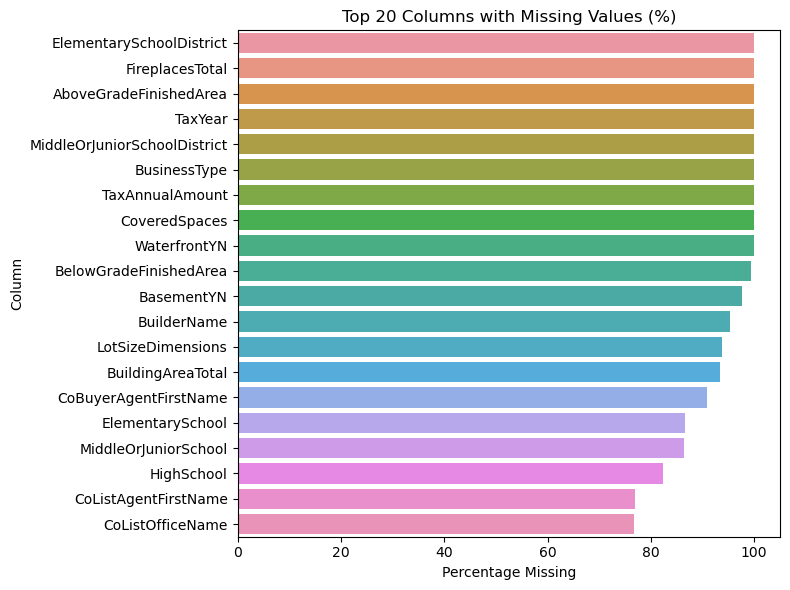

In [64]:
# 1) Compute % missing per column
missing = df_all.isna().mean().mul(100).sort_values(ascending=False)

# 2) Build a tidy table: Column | Missing %
miss_tbl = (
    missing[missing > 0]
    .round(2)
    .rename("Missing %")
    .to_frame()
    .reset_index()
    .rename(columns={"index": "Column"})
)

# 3) Print the table (top 20)
print("Top 20 columns with missing values (%):")
display(miss_tbl.head(20))

# 4) Plot the bar chart using tidy columns
plt.figure(figsize=(8, 6))
sns.barplot(
    data=miss_tbl.head(20),
    x="Missing %",
    y="Column",
)
plt.title("Top 20 Columns with Missing Values (%)")
plt.xlabel("Percentage Missing")
plt.ylabel("Column")
plt.tight_layout()
plt.show()

High-missing columns may be dropped if non-essential or imputed if predictive. Document the strategy column-by-column in preprocessing.

#### 1.3b Heatmap (Sample only)

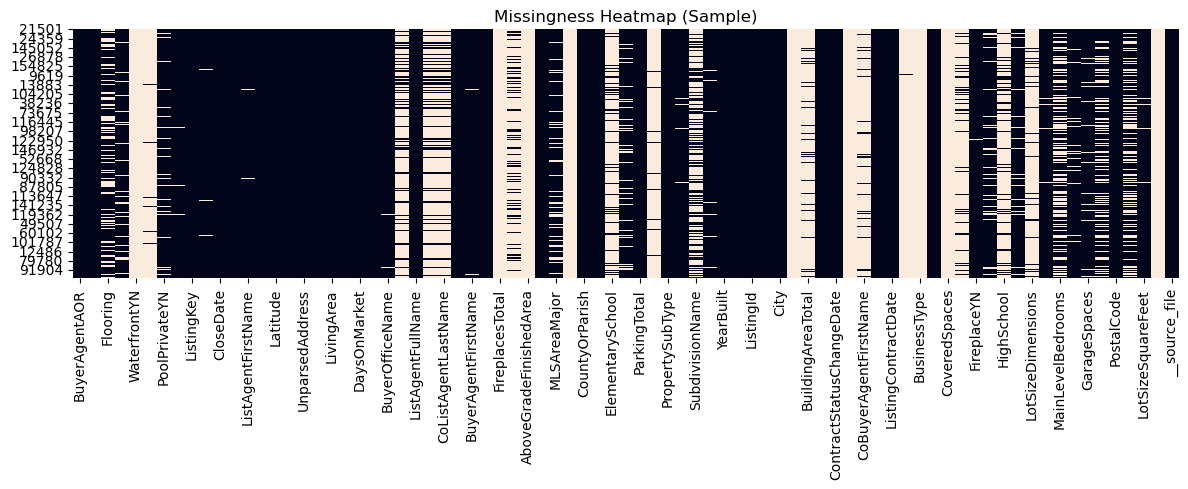

In [65]:
sample = df_all.sample(min(5000, len(df_all)), random_state=42)
plt.figure(figsize=(12,5))
sns.heatmap(sample.isna(), cbar=False)
plt.title("Missingness Heatmap (Sample)")
plt.tight_layout()
plt.show()

#### 1.4 Correlation & Feature Relationships

In [66]:
maybe_numeric = [
    "BedroomsTotal", "BathroomsTotalInteger", "BuildingAreaTotal",
    "LivingArea", "LotSizeSquareFeet", "GarageSpaces", "YearBuilt"
]
num_cols = [c for c in maybe_numeric if c in df_all.columns]
num_cols

['BedroomsTotal',
 'BathroomsTotalInteger',
 'BuildingAreaTotal',
 'LivingArea',
 'LotSizeSquareFeet',
 'GarageSpaces',
 'YearBuilt']

#### 1.4a Correlation with ClosePrice

,Correlation with ClosePrice
BuildingAreaTotal,0.781925
LivingArea,0.176213
BathroomsTotalInteger,0.153234
BedroomsTotal,0.100811
GarageSpaces,0.014424
YearBuilt,0.005759
LotSizeSquareFeet,0.002771


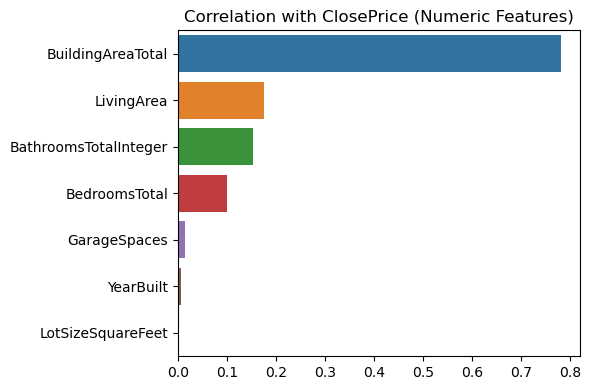

In [67]:
if num_cols:
    corr = df_all[num_cols + ["ClosePrice"]].corr(numeric_only=True)["ClosePrice"].drop("ClosePrice").sort_values(ascending=False)
    display(corr.to_frame("Correlation with ClosePrice"))
    plt.figure(figsize=(6,4))
    sns.barplot(x=corr.values, y=corr.index)
    plt.title("Correlation with ClosePrice (Numeric Features)")
    plt.tight_layout()
    plt.show()

#### 1.4b Scatter: area vs price

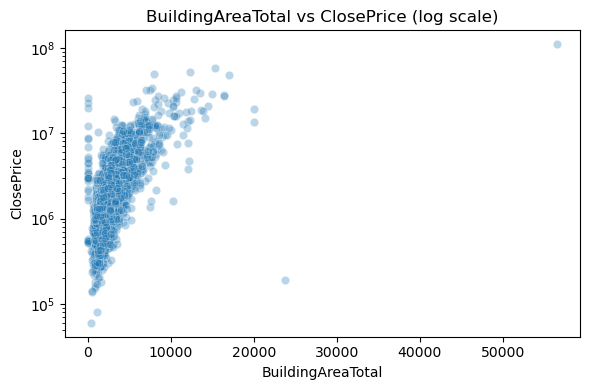

In [68]:
size_col = next((c for c in ["BuildingAreaTotal","LivingArea","LotSizeSquareFeet"] if c in df_all.columns), None)
if size_col:
    plot_df = df_all[[size_col, "ClosePrice"]].dropna().sample(min(5000, len(df_all)), random_state=42)
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=plot_df, x=size_col, y="ClosePrice", alpha=0.3)
    plt.yscale("log")
    plt.title(f"{size_col} vs ClosePrice (log scale)")
    plt.tight_layout()
    plt.show()

#### 1.4c Boxplot by county

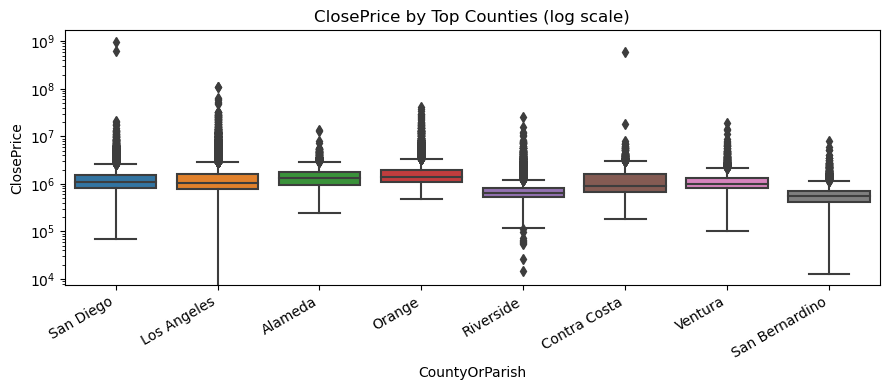

In [69]:
geo_col = next((c for c in ["CountyOrParish","County","CountyName"] if c in df_all.columns), None)
if geo_col:
    top_geo = df_all[geo_col].value_counts().head(8).index
    box_df = df_all[df_all[geo_col].isin(top_geo)][[geo_col,"ClosePrice"]].dropna()
    plt.figure(figsize=(9,4))
    sns.boxplot(data=box_df, x=geo_col, y="ClosePrice")
    plt.yscale("log")
    plt.title("ClosePrice by Top Counties (log scale)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

#### 1.4d Outlier Check (IQR Rule, Numeric Features)

Count values outside **[Q1 − 1.5·IQR, Q3 + 1.5·IQR]** to identify potential outliers that could destabilize models.

In [70]:
def iqr_outlier_counts(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    mask = (s < lower) | (s > upper)
    return int(mask.sum())

outlier_summary = pd.Series({c: iqr_outlier_counts(df_all[c].dropna()) for c in num_cols})
outlier_tbl = outlier_summary.sort_values(ascending=False).to_frame("Outlier Count").head(15)
display(outlier_tbl)

,Outlier Count
GarageSpaces,26311
LotSizeSquareFeet,10388
BathroomsTotalInteger,4645
LivingArea,3176
BedroomsTotal,2329
BuildingAreaTotal,317
YearBuilt,90


**Interpretation:** Consider capping/winsorizing extreme values (esp. `ClosePrice`, `SquareFeet`, `LotSize`) or using robust models if counts are high.

#### 1.4e Univariate Statistics (Selected Numeric Features)

We show mean/median/std and add **skew** to spot heavy tails (common for prices and square footage).

In [71]:
num_cols = df_all.select_dtypes("number").columns.tolist()
basic_desc = df_all[num_cols].describe().T
basic_desc["skew"] = df_all[num_cols].skew(numeric_only=True)
display(basic_desc.sort_values("skew", ascending=False).head(12))

,count,mean,std,min,25%,50%,75%,max,skew
LotSizeArea,77034.0,2.116391e+04,8.245687e+05,0.000000,5500.000000,7191.000000,1.001800e+04,2.178000e+08,243.073692
ParkingTotal,78386.0,3.244272e+00,6.760522e+01,-35.000000,2.000000,2.000000,3.000000e+00,1.572000e+04,202.207973
StreetNumberNumeric,78291.0,1.032947e+04,5.435713e+04,0.000000,1156.000000,3828.000000,1.330800e+04,1.058959e+07,177.395990
ClosePrice,78387.0,1.311684e+06,5.830554e+06,0.000000,630000.000000,900000.000000,1.450000e+06,9.700000e+08,134.087192
GarageSpaces,75254.0,2.007342e+00,3.238721e+00,0.000000,2.000000,2.000000,2.000000e+00,5.000000e+02,122.354095
OriginalListPrice,78230.0,1.391874e+06,8.301580e+06,0.000000,639578.750000,899011.500000,1.450000e+06,1.390000e+09,110.440710
LotSizeSquareFeet,77027.0,2.092298e+05,1.305294e+07,0.000000,5663.000000,7306.000000,1.045400e+04,2.087221e+09,109.714927
LotSizeAcres,77029.0,9.640856e+00,6.262152e+02,0.000000,0.130000,0.167800,2.400000e-01,6.839300e+04,89.458153
Longitude,78382.0,-1.186186e+02,2.920446e+00,-124.193201,-119.159322,-118.024255,-1.172603e+02,3.290000e+02,64.428429
ListPrice,78387.0,1.276637e+06,1.658779e+06,13000.000000,629000.000000,899000.000000,1.429850e+06,1.375000e+08,20.305224


**Interpretation:** Strong right-skew in `ClosePrice` (or your target) suggests trying a **log-transform** in modeling or using robust losses/scalers.

#### 1.4f Correlation with Target (Top 15)

We list the **absolute** Pearson correlations with the target (if detected) to justify feature relevance.

In [72]:
# Detect target
_target_candidates = ["ClosePrice", "Close_Price", "close_price", "Price", "SoldPrice", "SalePrice"]
target = next((t for t in _target_candidates if t in df_all.columns), None)

if target is None:
    print("Target not found. Set `target` to your price column.")
else:
    # Ensure target is numeric
    y = pd.to_numeric(df_all[target], errors="coerce")

    # Numeric features (including target); corrwith will handle alignment
    Xnum = df_all.select_dtypes("number")

    # Get correlations with target, drop target itself
    corr = Xnum.corrwith(y).drop(labels=[target], errors="ignore")

    corr_tbl = corr.abs().sort_values(ascending=False).to_frame("abs_corr")
    display(corr_tbl.head(15))

,abs_corr
BuildingAreaTotal,0.781925
ListPrice,0.276825
LivingArea,0.176213
BathroomsTotalInteger,0.153234
BedroomsTotal,0.100811
OriginalListPrice,0.055970
AssociationFee,0.052102
Stories,0.040085
LotSizeArea,0.033935
MainLevelBedrooms,0.019415


**Interpretation:** Strong absolute correlations provide a first-pass rationale for feature inclusion; low correlations don’t automatically mean “useless” (non-linear effects and interactions may still matter).

# **STEP 2 --> DATA PREPROCESSING**

Clean the dataset, handle missing values, encode categoricals, scale numerics, and split for model training/testing.

#### 2.1 Cleaning & Imputation

In [73]:
from sklearn.model_selection import train_test_split

In [74]:
# Drop obvious leakage or high-cardinality text columns
DROP_COLUMNS = [
    "ListingId","ListingKey","StandardStatus","ListingContractDate",
    "PhotosCount","PhotosChangeTimestamp","ModificationTimestamp",
    "PublicRemarks","PrivateRemarks","Directions","UnparsedAddress",
    "VirtualTourURLUnbranded","VirtualTourURLBranded","__source_file"
]

# Drop rows without ClosePrice
df = df_all.copy().dropna(subset=["ClosePrice"])

# Drop unwanted columns
df = df.drop(columns=[c for c in DROP_COLUMNS if c in df.columns], errors="ignore")

# Convert likely numeric fields
NUMERIC_CANDIDATES = [
    "BedroomsTotal","BathroomsTotalInteger","BuildingAreaTotal","LivingArea",
    "LotSizeSquareFeet","GarageSpaces","YearBuilt","StoriesTotal","ParkingTotal"
]
for c in [x for x in NUMERIC_CANDIDATES if x in df.columns]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    
# Boolean --> like columns → 0/1
yes_no_map = {"true":1,"t":1,"1":1,"yes":1,"y":1,"false":0,"f":0,"0":0,"no":0,"n":0}
for c in df.select_dtypes("object"):
    vals = df[c].astype(str).str.lower().str.strip()
    if set(vals.unique()) <= set(yes_no_map) | {"nan","none"}:
        df[c] = vals.map(yes_no_map).astype("float64")

print("✅ Clean shape:", df.shape)
display(df.head(5))

✅ Clean shape: (78387, 74)


,BuyerAgentAOR,ListAgentAOR,Flooring,ViewYN,WaterfrontYN,BasementYN,PoolPrivateYN,OriginalListPrice,ListAgentEmail,CloseDate,ClosePrice,ListAgentFirstName,ListAgentLastName,Latitude,Longitude,PropertyType,LivingArea,ListPrice,DaysOnMarket,ListOfficeName,BuyerOfficeName,CoListOfficeName,ListAgentFullName,CoListAgentFirstName,CoListAgentLastName,BuyerAgentMlsId,BuyerAgentFirstName,BuyerAgentLastName,FireplacesTotal,AssociationFeeFrequency,AboveGradeFinishedArea,ListingKeyNumeric,MLSAreaMajor,TaxAnnualAmount,CountyOrParish,MlsStatus,ElementarySchool,AttachedGarageYN,ParkingTotal,BuilderName,PropertySubType,LotSizeAcres,SubdivisionName,BuyerOfficeAOR,YearBuilt,StreetNumberNumeric,BathroomsTotalInteger,City,TaxYear,BuildingAreaTotal,BedroomsTotal,ContractStatusChangeDate,ElementarySchoolDistrict,CoBuyerAgentFirstName,PurchaseContractDate,BelowGradeFinishedArea,BusinessType,StateOrProvince,CoveredSpaces,MiddleOrJuniorSchool,FireplaceYN,Stories,HighSchool,Levels,LotSizeDimensions,LotSizeArea,MainLevelBedrooms,NewConstructionYN,GarageSpaces,HighSchoolDistrict,PostalCode,AssociationFee,LotSizeSquareFeet,MiddleOrJuniorSchoolDistrict
2,SanDiego,SanDiego,NaN,0.0,NaN,NaN,0.0,880000.0,lenskab@gmail.com,2025-02-11,875000.0,Lenska,Bracknell,32.765380,-117.043486,Residential,2340.0,880000.0,20,LENSKA Realty,Coldwell Banker West,NaN,Lenska Bracknell,NaN,NaN,809976,Sheetal,Gandhi,NaN,NaN,NaN,497696903,91942 - La Mesa,NaN,San Diego,Closed,NaN,1.0,6.0,NaN,SingleFamilyResidence,NaN,La Mesa,PacificSouthwest,2021.0,4750.0,4.0,La Mesa,NaN,NaN,4.0,2025-02-11,NaN,NaN,2021-01-25,NaN,NaN,CA,NaN,NaN,0.0,1.0,NaN,One,NaN,NaN,NaN,0.0,2.0,NaN,91942,NaN,NaN,NaN
3,SanDiego,SanDiego,NaN,0.0,NaN,NaN,0.0,875000.0,lenskab@gmail.com,2025-02-14,875000.0,Lenska,Bracknell,32.765038,-117.043568,Residential,2165.0,875000.0,9,LENSKA Realty,LENSKA Realty,NaN,Lenska Bracknell,NaN,NaN,SAND-649841,Lenska,Bracknell,NaN,NaN,NaN,497696407,91942 - La Mesa,NaN,San Diego,Closed,NaN,1.0,4.0,NaN,SingleFamilyResidence,NaN,La Mesa,SanDiego,2021.0,4740.0,4.0,La Mesa,NaN,NaN,5.0,2025-02-14,NaN,NaN,2021-01-14,NaN,NaN,CA,NaN,NaN,0.0,1.0,NaN,One,NaN,NaN,NaN,0.0,2.0,NaN,91942,NaN,NaN,NaN
4,SanDiego,SanDiego,NaN,0.0,NaN,NaN,0.0,849000.0,lenskab@gmail.com,2025-02-18,849000.0,Lenska,Bracknell,32.765031,-117.043252,Residential,2158.0,849000.0,91,LENSKA Realty,Heritage Homes San Diego,NaN,Lenska Bracknell,NaN,NaN,SAND-693007,Jason,Piske,NaN,NaN,NaN,486616176,91942 - La Mesa,NaN,San Diego,Closed,NaN,1.0,4.0,NaN,SingleFamilyResidence,NaN,La Mesa,SanDiego,2021.0,4730.0,3.0,La Mesa,NaN,NaN,4.0,2025-02-18,NaN,NaN,2021-01-25,NaN,NaN,CA,NaN,NaN,0.0,1.0,NaN,One,NaN,NaN,NaN,0.0,2.0,NaN,91942,NaN,NaN,NaN
15,SouthBay,SouthBay,Carpet,1.0,NaN,1.0,0.0,1100000.0,elaine@elainemallon.com,2025-02-28,1100000.0,Elaine,Mallon,33.724000,-118.294924,Residential,2545.0,1100000.0,0,Rodeo Realty,Rodeo Realty,NaN,Elaine Mallon,NaN,NaN,sbmallela,Elaine,Mallon,NaN,NaN,NaN,1108119618,183 - Vista Del Oro,NaN,Los Angeles,Closed,NaN,0.0,3.0,NaN,SingleFamilyResidence,0.1033,NaN,SouthBay,1962.0,2211.0,3.0,San Pedro,NaN,NaN,4.0,2025-02-28,NaN,NaN,2025-01-10,NaN,NaN,CA,NaN,NaN,1.0,2.0,San Pedro,Two,NaN,4501.0,4.0,0.0,2.0,Los Angeles Unified,90731,0.0,4501.0,NaN
16,ContraCosta,ContraCosta,Carpet,NaN,NaN,NaN,0.0,760000.0,sabine.larsen@redfin.com,2025-02-28,760000.0,Sabine,Larsen,37.687556,-122.150114,Residential,1692.0,760000.0,0,Redfin,Legacy Real Estate & Assoc.,NaN,Sabine Larsen,NaN,NaN,CCBE-206516251,Kristy,Peixoto,NaN,NaN,NaN,1108119338,NaN,NaN,Alameda,Closed,NaN,1.0,2.0,NaN,SingleFamilyResidence,0.1157,Not Listed,BayEast,1950.0,15216.0,2.0,San Leandro,NaN,NaN,4.0,2025-02-28,NaN,NaN,2025-02-28,NaN,NaN,CA,NaN,NaN,1.0,1.0,NaN,One,NaN,5040.0,NaN,0.0,2.0,NaN,94579,NaN,5040.0,NaN


#### 2.2 Split Train/Test and Identify Column Types

We verify that scaling was **fit on the training set only** and that scaled training features have mean≈0 and std≈1.

In [75]:
y = df["ClosePrice"].values
X = df.drop(columns=["ClosePrice"]).copy()

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]

print(f"Numeric columns: {len(num_cols)}")
print(f"Categorical columns: {len(cat_cols)}")

display(pd.DataFrame({
    "Numeric Columns": pd.Series(num_cols),
    "Categorical Columns": pd.Series(cat_cols)
}))

Numeric columns: 36
Categorical columns: 37


,Numeric Columns,Categorical Columns
0,ViewYN,BuyerAgentAOR
1,WaterfrontYN,ListAgentAOR
2,BasementYN,Flooring
3,PoolPrivateYN,ListAgentEmail
4,OriginalListPrice,CloseDate
5,Latitude,ListAgentFirstName
6,Longitude,ListAgentLastName
7,LivingArea,PropertyType
8,ListPrice,ListOfficeName
9,DaysOnMarket,BuyerOfficeName


In [76]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}")

Train shape: (62709, 73) | Test shape: (15678, 73)


**Interpretation:** If training mean(|μ|)≈0 and mean(σ)≈1, scaling was applied properly to the training set. The test set need not have σ≈1, but μ should be close to 0 if the same transform was applied.

#### 2.3 Pipelines (Impute + Scale/Encode)

In [77]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy import sparse

numeric_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=False))
])
cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocessor = ColumnTransformer(
    [("num", numeric_pipe, num_cols), ("cat", cat_pipe, cat_cols)],
    sparse_threshold=0.3,
)


print("✅ Preprocessing pipelines defined.")

✅ Preprocessing pipelines defined.


#### 2.4 Fit/Transform & Verify

In [78]:
Xt_train = preprocessor.fit_transform(X_train)
Xt_test  = preprocessor.transform(X_test)

def describe_sparse(mat):
    if sparse.issparse(mat):
        nnz = mat.nnz
        total = np.prod(mat.shape)
        return f"{mat.shape} | nnz={nnz:,} | density={nnz/total:.4%}"
    return f"{mat.shape} | dense"

print("Transformed X_train:", describe_sparse(Xt_train))
print("Transformed X_test: ", describe_sparse(Xt_test))

Transformed X_train: (62709, 192950) | nnz=3,789,753 | density=0.0313%
Transformed X_test:  (15678, 192950) | nnz=920,763 | density=0.0304%


In [79]:
# Retrieve feature names for reference
num_names = num_cols
try:
    cat_names = preprocessor.named_transformers_["cat"].named_steps["ohe"].get_feature_names_out(cat_cols)
except Exception:
    cat_names = []

feature_names = list(num_names) + list(cat_names)
print("Total features:", len(feature_names))
print("Sample features:", feature_names[:10])

Total features: 192958
Sample features: ['ViewYN', 'WaterfrontYN', 'BasementYN', 'PoolPrivateYN', 'OriginalListPrice', 'Latitude', 'Longitude', 'LivingArea', 'ListPrice', 'DaysOnMarket']


In [80]:
# Small summary table
summary_df = pd.DataFrame({
    "Type": ["Numeric","Categorical","Total Encoded"],
    "Count": [len(num_cols), len(cat_cols), len(feature_names)]
})
display(summary_df)

,Type,Count
0,Numeric,36
1,Categorical,37
2,Total Encoded,192958
